In [10]:
# 📘 Customer Satisfaction Predictor for HappyClient Solutions
print('Hello from YBI Foundation 🚀')

Hello from YBI Foundation 🚀


In [11]:
# ============================================================================
# Customer Satisfaction Predictor for HappyClient Solutions
# Business Context: Customer experience consultancy firm predicting client satisfaction
# ============================================================================

# STEP 1: IMPORT REQUIRED LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore')

In [12]:
# STEP 2: DATA GENERATION AND PREPARATION
# ============================================================================

def generate_customer_data(n_samples=1000, random_state=42):
    """
    Generate synthetic customer satisfaction data for training
    Args:
        n_samples (int): Number of samples to generate
        random_state (int): Random seed for reproducibility
    Returns:
        DataFrame: Generated customer data
    """
    np.random.seed(random_state)

    # Generate features
    data = {
        'customer_id': range(1, n_samples + 1),
        'response_time_hours': np.random.exponential(2, n_samples),  # Response time in hours
        'issue_complexity': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.1, 0.2, 0.4, 0.2, 0.1]),
        'agent_experience_months': np.random.normal(24, 12, n_samples),  # Agent experience
        'previous_interactions': np.random.poisson(3, n_samples),  # Number of previous interactions
        'survey_communication': np.random.normal(7, 1.5, n_samples),  # Communication score 1-10
        'survey_professionalism': np.random.normal(7.5, 1.2, n_samples),  # Professionalism score 1-10
        'survey_speed': np.random.normal(6.8, 1.8, n_samples),  # Speed score 1-10
        'channel': np.random.choice(['phone', 'email', 'chat', 'in_person'], n_samples,
                                  p=[0.4, 0.3, 0.25, 0.05]),
        'time_of_day': np.random.choice(['morning', 'afternoon', 'evening'], n_samples,
                                      p=[0.3, 0.5, 0.2]),
        'issue_type': np.random.choice(['technical', 'billing', 'general', 'complaint'], n_samples,
                                     p=[0.35, 0.25, 0.25, 0.15])
    }

    df = pd.DataFrame(data)

    # Ensure realistic bounds
    df['response_time_hours'] = np.clip(df['response_time_hours'], 0.1, 48)
    df['agent_experience_months'] = np.clip(df['agent_experience_months'], 1, 120)
    df['previous_interactions'] = np.clip(df['previous_interactions'], 0, 20)
    df['survey_communication'] = np.clip(df['survey_communication'], 1, 10)
    df['survey_professionalism'] = np.clip(df['survey_professionalism'], 1, 10)
    df['survey_speed'] = np.clip(df['survey_speed'], 1, 10)

    # Create derived features
    df['avg_survey_score'] = (df['survey_communication'] +
                             df['survey_professionalism'] +
                             df['survey_speed']) / 3

    # Generate satisfaction target based on realistic business logic
    satisfaction_score = (
        -0.3 * np.log(df['response_time_hours']) +  # Faster response = higher satisfaction
        -0.1 * df['issue_complexity'] +  # Complex issues = lower satisfaction
        0.02 * df['agent_experience_months'] +  # Experienced agents = higher satisfaction
        -0.05 * df['previous_interactions'] +  # Many interactions = frustration
        0.4 * df['avg_survey_score'] +  # Survey scores strongly predict satisfaction
        np.random.normal(0, 0.5, n_samples)  # Random noise
    )

    # Convert to binary satisfaction (1 = satisfied, 0 = not satisfied)
    df['satisfied'] = (satisfaction_score > np.median(satisfaction_score)).astype(int)

    return df

def load_data():
    """Load or generate customer satisfaction data"""
    print("📊 Generating customer satisfaction dataset...")
    df = generate_customer_data(n_samples=1500)
    print(f"✅ Dataset created with {len(df)} customer records")
    return df

In [13]:
# STEP 3: DATA EXPLORATION AND VISUALIZATION
# ============================================================================

def explore_data(df):
    """
    Perform exploratory data analysis
    Args:
        df (DataFrame): Customer data
    """
    print("\n📈 DATA EXPLORATION")
    print("=" * 60)

    # Basic info
    print(f"📊 Dataset Shape: {df.shape}")
    print(f"📋 Features: {list(df.columns)}")

    # Target distribution
    satisfaction_dist = df['satisfied'].value_counts()
    print(f"\n🎯 Target Distribution:")
    print(f"   Satisfied (1): {satisfaction_dist[1]} ({satisfaction_dist[1]/len(df)*100:.1f}%)")
    print(f"   Not Satisfied (0): {satisfaction_dist[0]} ({satisfaction_dist[0]/len(df)*100:.1f}%)")

    # Summary statistics
    print(f"\n📊 Summary Statistics:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(df[numeric_cols].describe().round(2))

    return df

def visualize_data(df):
    """
    Create visualizations for data understanding
    Args:
        df (DataFrame): Customer data
    """
    print("\n📊 Generating visualizations...")

    plt.figure(figsize=(15, 12))

    # 1. Target distribution
    plt.subplot(2, 3, 1)
    df['satisfied'].value_counts().plot(kind='bar', color=['red', 'green'])
    plt.title('Customer Satisfaction Distribution')
    plt.xlabel('Satisfied (0=No, 1=Yes)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    # 2. Response time vs satisfaction
    plt.subplot(2, 3, 2)
    df.boxplot(column='response_time_hours', by='satisfied', ax=plt.gca())
    plt.title('Response Time by Satisfaction')
    plt.suptitle('')

    # 3. Survey scores vs satisfaction
    plt.subplot(2, 3, 3)
    df.boxplot(column='avg_survey_score', by='satisfied', ax=plt.gca())
    plt.title('Average Survey Score by Satisfaction')
    plt.suptitle('')

    # 4. Channel distribution
    plt.subplot(2, 3, 4)
    channel_sat = pd.crosstab(df['channel'], df['satisfied'], normalize='index')
    channel_sat.plot(kind='bar', ax=plt.gca(), color=['red', 'green'])
    plt.title('Satisfaction Rate by Channel')
    plt.xlabel('Channel')
    plt.ylabel('Satisfaction Rate')
    plt.legend(['Not Satisfied', 'Satisfied'])
    plt.xticks(rotation=45)

    # 5. Issue complexity vs satisfaction
    plt.subplot(2, 3, 5)
    complexity_sat = df.groupby('issue_complexity')['satisfied'].mean()
    complexity_sat.plot(kind='bar', ax=plt.gca(), color='skyblue')
    plt.title('Satisfaction Rate by Issue Complexity')
    plt.xlabel('Issue Complexity (1-5)')
    plt.ylabel('Satisfaction Rate')
    plt.xticks(rotation=0)

    # 6. Correlation heatmap
    plt.subplot(2, 3, 6)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', square=True, ax=plt.gca())
    plt.title('Feature Correlation Matrix')

    plt.tight_layout()
    plt.show()

In [14]:
# STEP 4: DATA PREPROCESSING
# ============================================================================

def preprocess_data(df):
    """
    Preprocess data for machine learning
    Args:
        df (DataFrame): Raw customer data
    Returns:
        tuple: X (features), y (target), feature_names, encoders
    """
    print("\n🔧 PREPROCESSING DATA")
    print("=" * 40)

    # Create a copy for preprocessing
    df_processed = df.copy()

    # Handle categorical variables
    categorical_cols = ['channel', 'time_of_day', 'issue_type']
    encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
        encoders[col] = le
        print(f"✅ Encoded {col}: {list(le.classes_)}")

    # Select features for modeling
    feature_cols = [
        'response_time_hours', 'issue_complexity', 'agent_experience_months',
        'previous_interactions', 'survey_communication', 'survey_professionalism',
        'survey_speed', 'avg_survey_score', 'channel_encoded',
        'time_of_day_encoded', 'issue_type_encoded'
    ]

    X = df_processed[feature_cols]
    y = df_processed['satisfied']

    print(f"📊 Features selected: {len(feature_cols)}")
    print(f"🎯 Target variable: satisfied")
    print(f"📈 Data shape: {X.shape}")

    return X, y, feature_cols, encoders

In [15]:
# STEP 5: MODEL DEVELOPMENT
# ============================================================================

class CustomerSatisfactionPredictor:
    """Customer satisfaction prediction model"""

    def __init__(self):
        self.models = {
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'SVM': SVC(random_state=42, probability=True)
        }
        self.best_model = None
        self.best_model_name = None
        self.scaler = StandardScaler()
        self.feature_names = None
        self.is_trained = False

    def train_models(self, X, y, feature_names):
        """
        Train multiple models and select the best one
        Args:
            X: Feature matrix
            y: Target vector
            feature_names: List of feature names
        """
        print("\n🤖 TRAINING MODELS")
        print("=" * 50)

        self.feature_names = feature_names

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Store test data for evaluation
        self.X_test = X_test_scaled
        self.y_test = y_test

        model_performance = {}

        # Train and evaluate each model
        for name, model in self.models.items():
            print(f"\n🔄 Training {name}...")

            # Train model
            if name == 'Logistic Regression' or name == 'SVM':
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)

            model_performance[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }

            print(f"   Accuracy: {accuracy:.3f}")
            print(f"   Precision: {precision:.3f}")
            print(f"   Recall: {recall:.3f}")
            print(f"   F1-Score: {f1:.3f}")
            print(f"   AUC: {auc:.3f}")

        # Select best model based on F1-score (balance of precision and recall)
        best_model_name = max(model_performance.keys(),
                             key=lambda x: model_performance[x]['f1'])

        self.best_model = model_performance[best_model_name]['model']
        self.best_model_name = best_model_name
        self.model_performance = model_performance
        self.is_trained = True

        print(f"\n🏆 Best Model Selected: {best_model_name}")
        print(f"   F1-Score: {model_performance[best_model_name]['f1']:.3f}")

        return model_performance

    def predict(self, X):
        """Make predictions on new data"""
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")

        if self.best_model_name in ['Logistic Regression', 'SVM']:
            X_scaled = self.scaler.transform(X)
            return self.best_model.predict(X_scaled)
        else:
            return self.best_model.predict(X)

    def predict_proba(self, X):
        """Get prediction probabilities"""
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")

        if self.best_model_name in ['Logistic Regression', 'SVM']:
            X_scaled = self.scaler.transform(X)
            return self.best_model.predict_proba(X_scaled)
        else:
            return self.best_model.predict_proba(X)

In [16]:
# STEP 6: MODEL EVALUATION
# ============================================================================

def evaluate_model_performance(predictor):
    """
    Comprehensive model evaluation
    Args:
        predictor: Trained CustomerSatisfactionPredictor
    """
    print("\n📊 COMPREHENSIVE MODEL EVALUATION")
    print("=" * 60)

    best_performance = predictor.model_performance[predictor.best_model_name]
    y_true = predictor.y_test
    y_pred = best_performance['predictions']
    y_pred_proba = best_performance['probabilities']

    # Classification report
    print(f"\n📋 Classification Report ({predictor.best_model_name}):")
    print(classification_report(y_true, y_pred,
                              target_names=['Not Satisfied', 'Satisfied']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n📊 Confusion Matrix:")
    print(f"                 Predicted")
    print(f"Actual    Not Sat  Satisfied")
    print(f"Not Sat      {cm[0,0]:3d}      {cm[0,1]:3d}")
    print(f"Satisfied    {cm[1,0]:3d}      {cm[1,1]:3d}")

    # Business metrics
    tn, fp, fn, tp = cm.ravel()

    print(f"\n💼 Business Impact Metrics:")
    print(f"   True Positives (Correctly predicted satisfied): {tp}")
    print(f"   True Negatives (Correctly predicted unsatisfied): {tn}")
    print(f"   False Positives (Predicted satisfied, actually not): {fp}")
    print(f"   False Negatives (Predicted unsatisfied, actually satisfied): {fn}")

    # Cost analysis (assuming business costs)
    cost_fp = fp * 10  # Cost of overestimating satisfaction
    cost_fn = fn * 50  # Cost of underestimating satisfaction (more critical)
    total_cost = cost_fp + cost_fn

    print(f"\n💰 Estimated Business Cost:")
    print(f"   False Positive Cost: ${cost_fp} (${10} per case)")
    print(f"   False Negative Cost: ${cost_fn} (${50} per case)")
    print(f"   Total Model Cost: ${total_cost}")

def plot_model_evaluation(predictor):
    """
    Create evaluation plots
    Args:
        predictor: Trained CustomerSatisfactionPredictor
    """
    print("\n📊 Generating evaluation plots...")

    best_performance = predictor.model_performance[predictor.best_model_name]
    y_true = predictor.y_test
    y_pred_proba = best_performance['probabilities']

    plt.figure(figsize=(15, 5))

    # 1. Model comparison
    plt.subplot(1, 3, 1)
    models = list(predictor.model_performance.keys())
    f1_scores = [predictor.model_performance[m]['f1'] for m in models]

    bars = plt.bar(models, f1_scores, color=['gold' if m == predictor.best_model_name else 'skyblue'
                                           for m in models])
    plt.title('Model Performance Comparison (F1-Score)')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    # 2. ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)

    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # 3. Precision-Recall Curve
    plt.subplot(1, 3, 3)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)

    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.tight_layout()
    plt.show()



In [17]:
# STEP 7: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

def analyze_feature_importance(predictor):
    """
    Analyze feature importance for business insights
    Args:
        predictor: Trained CustomerSatisfactionPredictor
    """
    print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
    print("=" * 50)

    if predictor.best_model_name == 'Random Forest':
        # Get feature importance from Random Forest
        importance = predictor.best_model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': predictor.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        print("📊 Feature Importance (Random Forest):")
        for idx, row in feature_importance.iterrows():
            print(f"   {row['feature']:25s}: {row['importance']:.4f}")

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
        plt.title('Feature Importance for Customer Satisfaction Prediction')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

    elif predictor.best_model_name == 'Logistic Regression':
        # Get coefficients from Logistic Regression
        coefficients = predictor.best_model.coef_[0]
        feature_coef = pd.DataFrame({
            'feature': predictor.feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        }).sort_values('abs_coefficient', ascending=False)

        print("📊 Feature Coefficients (Logistic Regression):")
        for idx, row in feature_coef.iterrows():
            direction = "increases" if row['coefficient'] > 0 else "decreases"
            print(f"   {row['feature']:25s}: {row['coefficient']:7.4f} ({direction} satisfaction)")


In [18]:
# STEP 8: SATISFACTION REPORTING
# ============================================================================

def generate_satisfaction_report(df, predictor):
    """
    Generate comprehensive satisfaction report for business insights
    Args:
        df: Original customer data
        predictor: Trained model
    """
    print("\n📋 CUSTOMER SATISFACTION REPORT")
    print("=" * 60)

    # Overall satisfaction metrics
    overall_satisfaction = df['satisfied'].mean()
    total_customers = len(df)
    satisfied_customers = df['satisfied'].sum()

    print(f"📊 OVERALL SATISFACTION METRICS")
    print(f"   Total Customers Analyzed: {total_customers:,}")
    print(f"   Satisfied Customers: {satisfied_customers:,}")
    print(f"   Overall Satisfaction Rate: {overall_satisfaction:.1%}")

    # Satisfaction by channel
    print(f"\n📱 SATISFACTION BY CHANNEL:")
    channel_satisfaction = df.groupby('channel').agg({
        'satisfied': ['count', 'sum', 'mean']
    }).round(3)
    channel_satisfaction.columns = ['Total_Customers', 'Satisfied_Customers', 'Satisfaction_Rate']

    for channel, row in channel_satisfaction.iterrows():
        print(f"   {channel.title():12s}: {row['Satisfaction_Rate']:.1%} "
              f"({row['Satisfied_Customers']:.0f}/{row['Total_Customers']:.0f})")

    # Satisfaction by issue type
    print(f"\n🔧 SATISFACTION BY ISSUE TYPE:")
    issue_satisfaction = df.groupby('issue_type').agg({
        'satisfied': ['count', 'sum', 'mean']
    }).round(3)
    issue_satisfaction.columns = ['Total_Customers', 'Satisfied_Customers', 'Satisfaction_Rate']

    for issue_type, row in issue_satisfaction.iterrows():
        print(f"   {issue_type.title():12s}: {row['Satisfaction_Rate']:.1%} "
              f"({row['Satisfied_Customers']:.0f}/{row['Total_Customers']:.0f})")

    # Key insights
    print(f"\n💡 KEY INSIGHTS:")

    # Best and worst performing channels
    best_channel = channel_satisfaction['Satisfaction_Rate'].idxmax()
    worst_channel = channel_satisfaction['Satisfaction_Rate'].idxmin()

    print(f"   🏆 Best Channel: {best_channel.title()} "
          f"({channel_satisfaction.loc[best_channel, 'Satisfaction_Rate']:.1%})")
    print(f"   ⚠️  Worst Channel: {worst_channel.title()} "
          f"({channel_satisfaction.loc[worst_channel, 'Satisfaction_Rate']:.1%})")

    # Response time analysis
    satisfied_avg_response = df[df['satisfied']==1]['response_time_hours'].mean()
    unsatisfied_avg_response = df[df['satisfied']==0]['response_time_hours'].mean()

    print(f"   ⏱️  Avg Response Time (Satisfied): {satisfied_avg_response:.1f} hours")
    print(f"   ⏱️  Avg Response Time (Unsatisfied): {unsatisfied_avg_response:.1f} hours")

    # Survey score analysis
    satisfied_avg_survey = df[df['satisfied']==1]['avg_survey_score'].mean()
    unsatisfied_avg_survey = df[df['satisfied']==0]['avg_survey_score'].mean()

    print(f"   📊 Avg Survey Score (Satisfied): {satisfied_avg_survey:.1f}/10")
    print(f"   📊 Avg Survey Score (Unsatisfied): {unsatisfied_avg_survey:.1f}/10")

def generate_improvement_recommendations(df, predictor):
    """
    Generate actionable recommendations for service improvement
    Args:
        df: Customer data
        predictor: Trained model
    """
    print(f"\n🚀 SERVICE IMPROVEMENT RECOMMENDATIONS")
    print("=" * 60)

    # Response time recommendations
    avg_response_time = df['response_time_hours'].mean()
    satisfied_response_time = df[df['satisfied']==1]['response_time_hours'].mean()

    print(f"1. 📞 RESPONSE TIME OPTIMIZATION:")
    print(f"   Current avg response time: {avg_response_time:.1f} hours")
    print(f"   Target response time: {satisfied_response_time:.1f} hours")
    if avg_response_time > satisfied_response_time:
        improvement = avg_response_time - satisfied_response_time
        print(f"   💡 Reduce response time by {improvement:.1f} hours to improve satisfaction")

    # Channel optimization
    channel_satisfaction = df.groupby('channel')['satisfied'].mean()
    best_channel = channel_satisfaction.idxmax()
    worst_channel = channel_satisfaction.idxmin()

    print(f"\n2. 📱 CHANNEL OPTIMIZATION:")
    print(f"   🏆 Promote {best_channel} channel (highest satisfaction: {channel_satisfaction[best_channel]:.1%})")
    print(f"   🔧 Improve {worst_channel} channel (lowest satisfaction: {channel_satisfaction[worst_channel]:.1%})")

    # Training recommendations
    agent_experience_impact = df.groupby(pd.cut(df['agent_experience_months'],
                                               bins=[0, 12, 24, 60, 120],
                                               labels=['0-1yr', '1-2yr', '2-5yr', '5yr+']))['satisfied'].mean()

    print(f"\n3. 👥 AGENT TRAINING:")
    print(f"   Satisfaction by agent experience:")
    for exp_level, satisfaction in agent_experience_impact.items():
        print(f"      {exp_level}: {satisfaction:.1%}")

    # Survey score improvements
    low_survey_threshold = 6.0
    low_survey_customers = df[df['avg_survey_score'] < low_survey_threshold]

    print(f"\n4. 📊 SURVEY SCORE IMPROVEMENTS:")
    print(f"   {len(low_survey_customers)} customers with survey scores < {low_survey_threshold}")
    print(f"   Focus areas for improvement:")
    print(f"      Communication: {low_survey_customers['survey_communication'].mean():.1f}/10")
    print(f"      Professionalism: {low_survey_customers['survey_professionalism'].mean():.1f}/10")
    print(f"      Speed: {low_survey_customers['survey_speed'].mean():.1f}/10")


In [19]:
# STEP 9: PREDICTION INTERFACE
# ============================================================================

def predict_customer_satisfaction(predictor, customer_data):
    """
    Predict satisfaction for new customer data
    Args:
        predictor: Trained model
        customer_data: Dictionary with customer features
    Returns:
        dict: Prediction results
    """
    # Convert customer data to DataFrame
    df_customer = pd.DataFrame([customer_data])

    # Get prediction and probability
    prediction = predictor.predict(df_customer)[0]
    probability = predictor.predict_proba(df_customer)[0]

    confidence = max(probability)
    satisfaction_probability = probability[1]

    result = {
        'prediction': 'Satisfied' if prediction == 1 else 'Not Satisfied',
        'satisfaction_probability': satisfaction_probability,
        'confidence': confidence,
        'recommendation': 'Monitor closely' if satisfaction_probability < 0.7 else 'Good standing'
    }

    return result

def interactive_prediction():
    """Interactive prediction interface"""
    print(f"\n🔮 INTERACTIVE SATISFACTION PREDICTION")
    print("=" * 50)

    # Sample customer data for prediction
    sample_customers = [
        {
            'response_time_hours': 1.5,
            'issue_complexity': 2,
            'agent_experience_months': 36,
            'previous_interactions': 1,
            'survey_communication': 8.5,
            'survey_professionalism': 9.0,
            'survey_speed': 8.0,
            'avg_survey_score': 8.5,
            'channel_encoded': 0,  # phone
            'time_of_day_encoded': 1,  # afternoon
            'issue_type_encoded': 2  # general
        },
        {
            'response_time_hours': 8.5,
            'issue_complexity': 5,
            'agent_experience_months': 6,
            'previous_interactions': 5,
            'survey_communication': 4.0,
            'survey_professionalism': 4.5,
            'survey_speed': 3.5,
            'avg_survey_score': 4.0,
            'channel_encoded': 1,  # email
            'time_of_day_encoded': 2,  # evening
            'issue_type_encoded': 3  # complaint
        }
    ]

    return sample_customers



In [20]:
# STEP 10: MAIN EXECUTION PIPELINE
# ============================================================================

def main():
    """Main execution pipeline for customer satisfaction prediction"""
    print("🏢 HAPPYCLIENT SOLUTIONS - CUSTOMER SATISFACTION PREDICTOR")
    print("=" * 70)

    # Load and explore data
    df = load_data()
    df = explore_data(df)

    # Visualize data
    visualize_data(df)

    # Preprocess data
    X, y, feature_names, encoders = preprocess_data(df)

    # Train models
    predictor = CustomerSatisfactionPredictor()
    model_performance = predictor.train_models(X, y, feature_names)

    # Evaluate models
    evaluate_model_performance(predictor)
    plot_model_evaluation(predictor)

    # Analyze feature importance
    analyze_feature_importance(predictor)

    # Generate reports
    generate_satisfaction_report(df, predictor)
    generate_improvement_recommendations(df, predictor)

    # Interactive predictions
    sample_customers = interactive_prediction()

    print(f"\n🔮 Sample Predictions:")
    for i, customer in enumerate(sample_customers, 1):
        result = predict_customer_satisfaction(predictor, customer)
        print(f"\n   Customer {i}:")
        print(f"      Prediction: {result['prediction']}")
        print(f"      Satisfaction Probability: {result['satisfaction_probability']:.1%}")
        print(f"      Confidence: {result['confidence']:.1%}")
        print(f"      Recommendation: {result['recommendation']}")

    print(f"\n✅ Customer Satisfaction Analysis Complete!")

    return predictor, df



🏢 HAPPYCLIENT SOLUTIONS - CUSTOMER SATISFACTION PREDICTOR
📊 Generating customer satisfaction dataset...
✅ Dataset created with 1500 customer records

📈 DATA EXPLORATION
📊 Dataset Shape: (1500, 13)
📋 Features: ['customer_id', 'response_time_hours', 'issue_complexity', 'agent_experience_months', 'previous_interactions', 'survey_communication', 'survey_professionalism', 'survey_speed', 'channel', 'time_of_day', 'issue_type', 'avg_survey_score', 'satisfied']

🎯 Target Distribution:
   Satisfied (1): 750 (50.0%)
   Not Satisfied (0): 750 (50.0%)

📊 Summary Statistics:
       customer_id  response_time_hours  issue_complexity  \
count      1500.00              1500.00            1500.0   
mean        750.50                 2.02               3.0   
std         433.16                 2.02               1.1   
min           1.00                 0.10               1.0   
25%         375.75                 0.54               2.0   
50%         750.50                 1.41               3.0   
75%

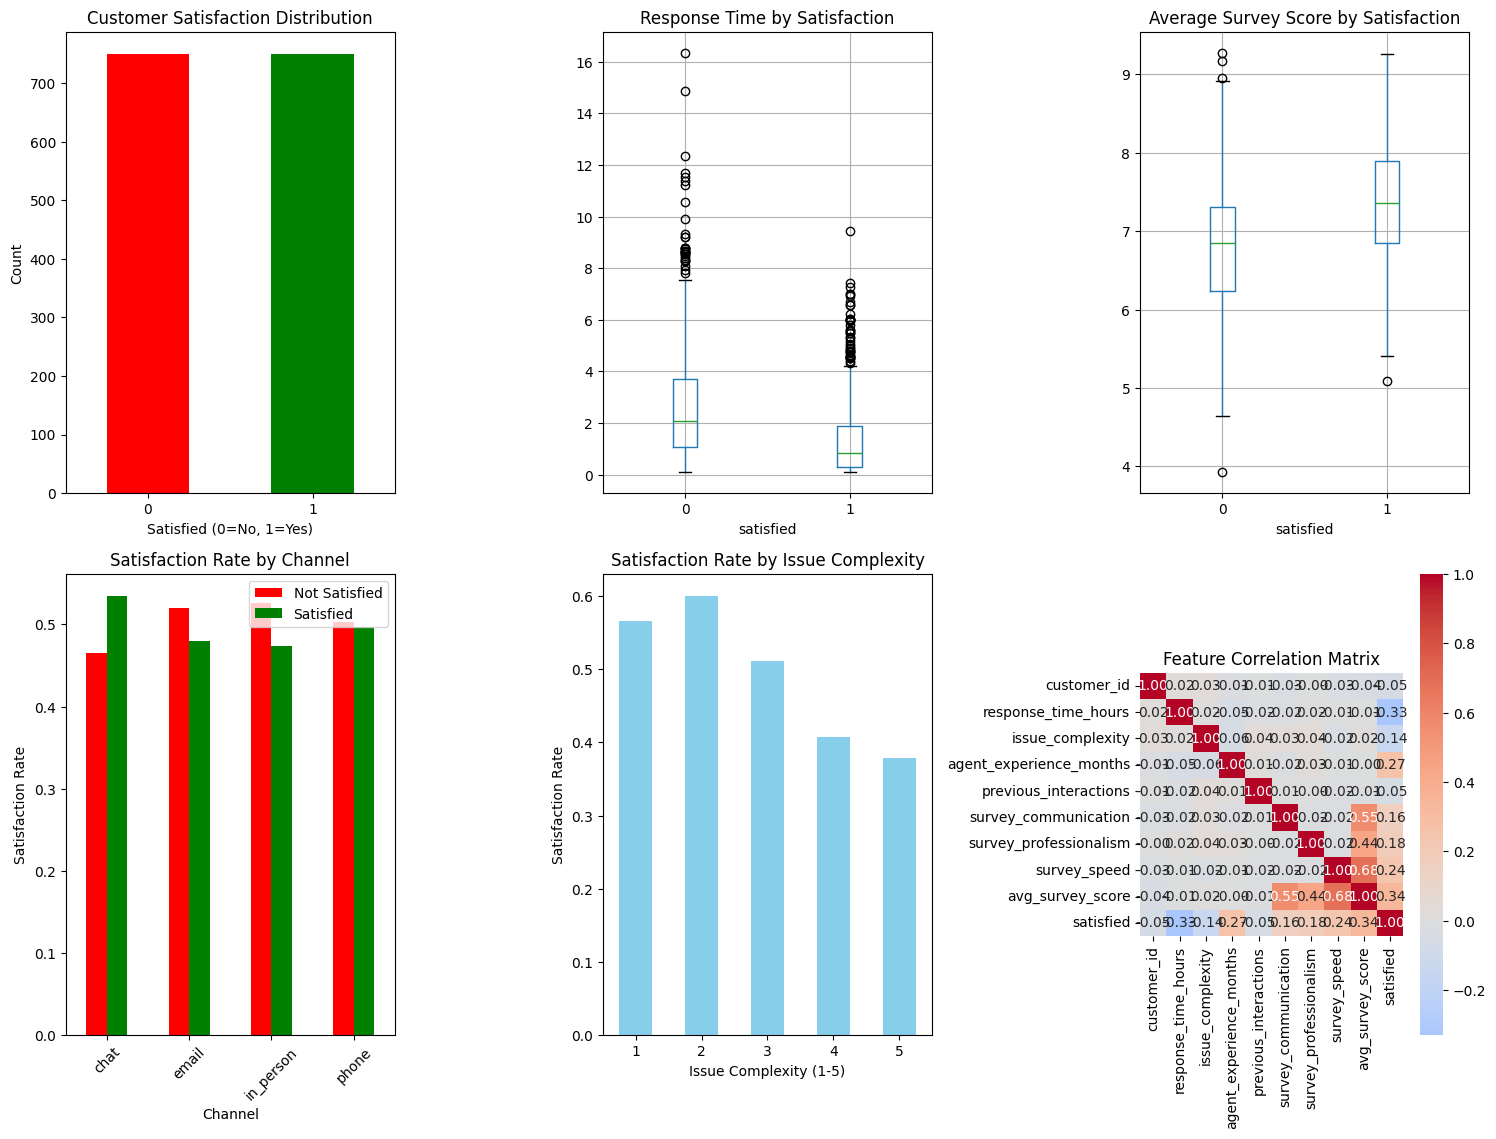


🔧 PREPROCESSING DATA
✅ Encoded channel: ['chat', 'email', 'in_person', 'phone']
✅ Encoded time_of_day: ['afternoon', 'evening', 'morning']
✅ Encoded issue_type: ['billing', 'complaint', 'general', 'technical']
📊 Features selected: 11
🎯 Target variable: satisfied
📈 Data shape: (1500, 11)

🤖 TRAINING MODELS

🔄 Training Random Forest...
   Accuracy: 0.767
   Precision: 0.808
   Recall: 0.700
   F1-Score: 0.750
   AUC: 0.826

🔄 Training Logistic Regression...
   Accuracy: 0.767
   Precision: 0.778
   Recall: 0.747
   F1-Score: 0.762
   AUC: 0.843

🔄 Training SVM...
   Accuracy: 0.753
   Precision: 0.788
   Recall: 0.693
   F1-Score: 0.738
   AUC: 0.823

🏆 Best Model Selected: Logistic Regression
   F1-Score: 0.762

📊 COMPREHENSIVE MODEL EVALUATION

📋 Classification Report (Logistic Regression):
               precision    recall  f1-score   support

Not Satisfied       0.76      0.79      0.77       150
    Satisfied       0.78      0.75      0.76       150

     accuracy                 

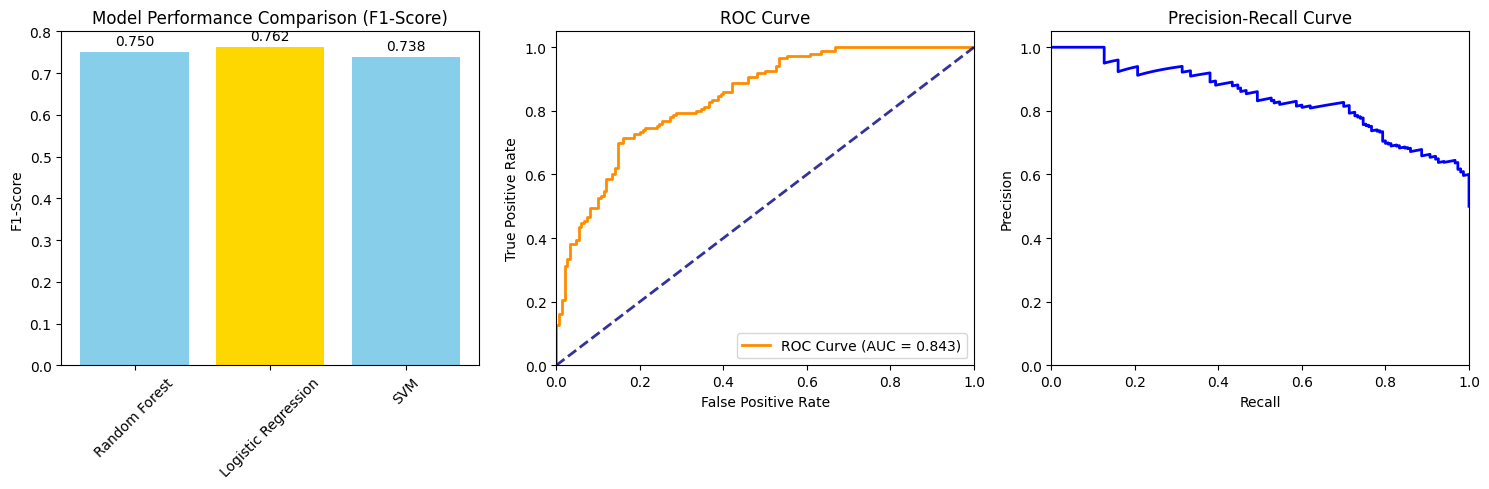


🔍 FEATURE IMPORTANCE ANALYSIS
📊 Feature Coefficients (Logistic Regression):
   response_time_hours      : -1.0782 (decreases satisfaction)
   agent_experience_months  :  0.6872 (increases satisfaction)
   avg_survey_score         :  0.4976 (increases satisfaction)
   survey_speed             :  0.3633 (increases satisfaction)
   issue_complexity         : -0.3575 (decreases satisfaction)
   survey_professionalism   :  0.2883 (increases satisfaction)
   survey_communication     :  0.1895 (increases satisfaction)
   previous_interactions    : -0.1419 (decreases satisfaction)
   issue_type_encoded       : -0.1095 (decreases satisfaction)
   time_of_day_encoded      :  0.0829 (increases satisfaction)
   channel_encoded          : -0.0260 (decreases satisfaction)

📋 CUSTOMER SATISFACTION REPORT
📊 OVERALL SATISFACTION METRICS
   Total Customers Analyzed: 1,500
   Satisfied Customers: 750
   Overall Satisfaction Rate: 50.0%

📱 SATISFACTION BY CHANNEL:
   Chat        : 53.5% (206/385)
   Emai

In [21]:
# STEP 11: EXPORT FUNCTIONALITY
# ============================================================================

def export_results(df, predictor, filename="satisfaction_analysis_results.csv"):
    """
    Export analysis results
    Args:
        df: Customer data
        predictor: Trained model
        filename: Output filename
    """
    # Create predictions for all data
    X, _, feature_names, _ = preprocess_data(df)
    predictions = predictor.predict(X)
    probabilities = predictor.predict_proba(X)[:, 1]

    # Add predictions to original data
    results_df = df.copy()
    results_df['predicted_satisfaction'] = predictions
    results_df['satisfaction_probability'] = probabilities
    results_df['prediction_correct'] = (predictions == df['satisfied'])

    # Export to CSV
    results_df.to_csv(filename, index=False)
    print(f"📁 Results exported to {filename}")

    return results_df

if __name__ == "__main__":
    # Execute main pipeline
    predictor, df = main()

    # Export results
    results_df = export_results(df, predictor)

    print(f"\n🎯 Model ready for deployment in production environment!")